# 一、项目介绍
这是泰坦尼克号幸存者数据
# 二、数据整理
## 2.1 加载数据

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
train.rename(columns=lambda x: x.lower(), inplace=True)
print(train.shape)
train.sample(3)

(891, 12)


,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
163,164,0,3,"Calic, Mr. Jovo",male,17.0,0,0,315093,8.6625,NaN,S
713,714,0,3,"Larsson, Mr. August Viktor",male,29.0,0,0,7545,9.4833,NaN,S
623,624,0,3,"Hansen, Mr. Henry Damsgaard",male,21.0,0,0,350029,7.8542,NaN,S


## 2.2 查看数据

In [1]:
test = pd.read_csv('test.csv')
test.rename(columns=lambda x: x.lower(), inplace=True)
print(test.shape)
test.head(3)

NameError: name 'pd' is not defined

train共有12列，test共有11列，前者比后者多一列'servived'用于训练机器学习。其他11列分别为：'PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'

In [4]:
data = pd.concat([train,test],axis=0)
data.rename(columns=lambda x: x.lower(), inplace=True)
print(data.shape)
data.sample(5)

(1309, 12)


,age,cabin,embarked,fare,name,parch,passengerid,pclass,sex,sibsp,survived,ticket
200,28.0,NaN,S,9.500,"Vande Walle, Mr. Nestor Cyriel",0,201,3,male,0,0.0,345770
47,NaN,NaN,Q,7.750,"Shaughnessy, Mr. Patrick",0,939,3,male,0,NaN,370374
171,27.0,NaN,C,7.225,"Zakarian, Mr. Ortin",0,1063,3,male,0,NaN,2670
461,34.0,NaN,S,8.050,"Morley, Mr. William",0,462,3,male,0,0.0,364506
720,6.0,NaN,S,33.000,"Harper, Miss. Annie Jessie ""Nina""",1,721,2,female,0,1.0,248727


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
age            1046 non-null float64
cabin          295 non-null object
embarked       1307 non-null object
fare           1308 non-null float64
name           1309 non-null object
parch          1309 non-null int64
passengerid    1309 non-null int64
pclass         1309 non-null int64
sex            1309 non-null object
sibsp          1309 non-null int64
survived       891 non-null float64
ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


从上可见，数据集包含12个变量，1309条数据，其中891条为训练数据，418条为测试数据

age 浮点数变量，标识乘客年龄，有缺失值

cabin 字符型，代表乘客所在的舱位，有缺失值  

embarked 字符型，代表乘客登船口岸，适合转换为factor型变量 

fare 浮点数变量，代表乘客的船票价  

name 字符型变量，除包含姓和名以外，还包含Mr. Mrs. Dr.这样的具有西方文化特点的信息  

parch 整型变量，代表父母或子女的个数。其中Par代表Parent也即父母，Ch代表Child也即子女  

passengerId 整型变量，标识乘客的ID，递增变量，对预测无帮助  

pclass 整型变量，标识乘客的社会-经济状态，1代表Upper，2代表Middle，3代表Lower  

sex 字符型变量，标识乘客性别，适合转换为整型变量

sibsp 整型变量，代表兄弟姐妹及配偶的个数。其中Sib代表Sibling也即兄弟姐妹，Sp代表Spouse也即配偶

survived 浮点数变量，标识该乘客是否幸存。0.0表示遇难，1.0表示幸存。需要转换为整型变量。 

ticket 字符型变量，代表乘客的船票信息  

In [6]:
age = pd.DataFrame(data['age'].value_counts())

In [7]:
data.isnull().sum()

age             263
cabin          1014
embarked          2
fare              1
name              0
parch             0
passengerid       0
pclass            0
sex               0
sibsp             0
survived        418
ticket            0
dtype: int64

#### 数据概况  
训练数据和测试数据共1309条。  
其中age缺失值263条，cabin缺失1014条，缺失较为严重。embarked缺失2个，fare缺失一条数据。

In [8]:
data.describe()

,age,fare,parch,passengerid,pclass,sibsp,survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


#### 乘客概况：  
年龄范围0-80岁，平均年龄30岁左右，；  
大部分乘客没有携带家属；  
票价范围0-512美元，只有极少量购买了512的船票；    
1等船仓、2等船仓人数同样较少，3等船仓人数占比过半；  
约有38%地人最终获救。

# 三、数据可视化

## 3.1女性幸存率远高于男性

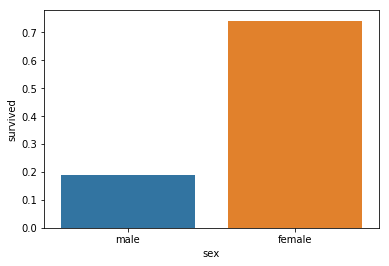

In [9]:
sb.barplot(data=train, x='sex', y='survived', ci= None);

女性幸存率为74%，男性幸村率为19%。可见女性幸村率远高于男性。

## 3.2船舱等级越高，幸存率越高

In [10]:
df_pclass = train[['survived','pclass']].groupby('pclass').mean()
df_pclass

,survived
pclass,
1,0.629630
2,0.472826
3,0.242363


1、2、3等船舱幸存率分别为63.0%、47.3%、24%。

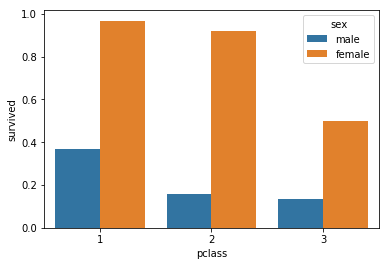

In [11]:
sb.barplot(data=train,x='pclass',y='survived',hue='sex',ci=None)

从幸存者分析，第一遵循女性优先的原则，因此1，2等船舱分别由97%、92%的女性获救，而第三等船舱女性获救比例为50%（后续分析三等船舱获救者特征）；  

In [14]:
survived = train[train['survived'] ==1][train['pclass'] ==3][train['sex'] =='female']
unlucky = train[train['survived'] ==0][train['pclass'] ==3][train['sex'] =='female'];

In [15]:
survived.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,72.000000,72.0,72.0,47.000000,72.000000,72.000000,72.000000
mean,359.083333,1.0,3.0,19.329787,0.500000,0.500000,12.464526
std,266.188419,0.0,0.0,12.303246,0.888106,0.919277,5.984714
min,3.000000,1.0,3.0,0.750000,0.000000,0.000000,7.225000
25%,138.750000,1.0,3.0,13.500000,0.000000,0.000000,7.750000
50%,322.500000,1.0,3.0,19.000000,0.000000,0.000000,9.468750
75%,563.500000,1.0,3.0,26.500000,1.000000,1.000000,15.912500
max,876.000000,1.0,3.0,63.000000,4.000000,5.000000,31.387500


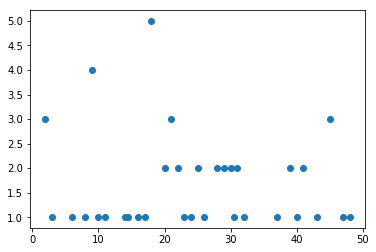

In [16]:
a = unlucky['age'].value_counts()
b = survived['age'].value_counts()
plt.scatter(a.index,a);
#plt.scatter(b.index,b);

## 3.3幸存者与年龄的关系

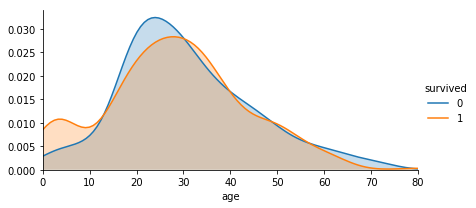

In [17]:
facet = sb.FacetGrid(train, hue="survived",aspect=2)
facet.map(sb.kdeplot,'age',shade= True)
facet.set(xlim=(0, data['age'].max()))
facet.add_legend();

未成年幸存者幸村率高于成年人。

## 3.4幸存者与家庭组成的关系

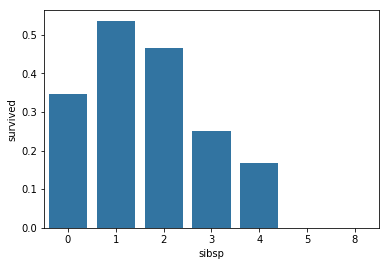

In [18]:
base_color = sb.color_palette()[0]
sb.barplot(x="sibsp", y="survived", data=train, ci=None,color=base_color);

配偶及兄弟姐妹数适中的乘客幸存率更高。

## 3.5幸存者与支出船票的关系

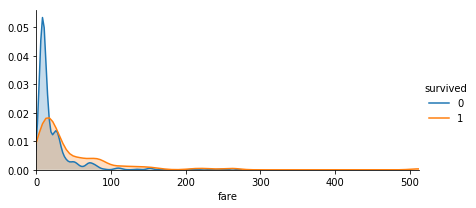

In [19]:
facet = sb.FacetGrid(train, hue="survived",aspect=2)
facet.map(sb.kdeplot,'fare',shade= True)
facet.set(xlim=(0, train['fare'].max()))
facet.add_legend();

支付船票费越高的乘客幸存率更高。

## 3.5不同称呼的乘客幸存率差异
新增title特征，从姓名中提取乘客的称呼，归纳为六类。

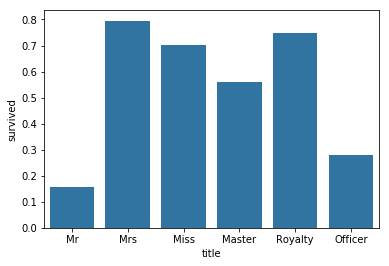

In [20]:
train['title'] = train['name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))
train['title'] = train['title'].map(Title_Dict)
sb.barplot(x="title", y="survived", data=train, ci=None,color=base_color);

父母与子女数适中的乘客幸存率更高。

# 四、数据清洗
## 4.1缺失值填充

**Age Feature**：Age缺失量为263，缺失量较大，用Sex, Title, Pclass三个特征构建随机森林模型，填充年龄缺失值。

In [21]:
data['title'] = data['name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))
data['title'] = data['title'].map(Title_Dict)

In [22]:
age_df = data[['age', 'pclass','sex','title']]
age_df=pd.get_dummies(age_df)
known_age = age_df[age_df.age.notnull()].as_matrix()
unknown_age = age_df[age_df.age.isnull()].as_matrix()
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1::])
data.loc[ (data.age.isnull()), 'age' ] = predictedAges 

In [23]:
bins =[0,10,20,30,40,50,60,70,100]
pd.cut(list(data['age']),bins)

[(20, 30], (30, 40], (20, 30], (30, 40], (30, 40], ..., (20, 30], (30, 40], (30, 40], (20, 30], (0, 10]]
Length: 1309
Categories (8, interval[int64]): [(0, 10] < (10, 20] < (20, 30] < (30, 40] < (40, 50] < (50, 60] < (60, 70] < (70, 100]]

In [24]:
bins =[0,10,20,30,40,50,60,70,100]
age_cut = pd.cut(list(data['age']),bins)
data['age_categ'] = pd.cut(data['age'],bins) #labels=['','']

**Embarked Feature**：Embarked缺失量为2，缺失Embarked信息的乘客的Pclass均为1，且Fare均为80，因为Embarked为C且Pclass为1的乘客的Fare中位数为80，所以缺失值填充为C。

In [34]:
data[data['embarked'].isnull()]

,age,cabin,embarked,fare,name,parch,passengerid,pclass,sex,sibsp,survived,ticket,title,age_categ
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,"(30, 40]"
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,"(60, 70]"


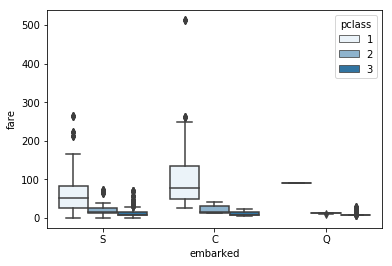

In [35]:
sb.boxplot(x="embarked", y="fare", hue="pclass",data=data, color=base_color);

In [36]:
data[(data['embarked']=='C')&(data['pclass']==1)].describe()

,age,fare,parch,passengerid,pclass,sibsp,survived
count,141.000000,141.000000,141.000000,141.000000,141.0,141.000000,85.000000
mean,39.331365,106.845330,0.368794,700.702128,1.0,0.397163,0.694118
std,13.262649,96.837527,0.669876,378.568879,0.0,0.532909,0.463515
min,6.000000,25.741700,0.000000,2.000000,1.0,0.000000,0.000000
25%,28.500000,49.504200,0.000000,370.000000,1.0,0.000000,0.000000
50%,40.000000,76.729200,0.000000,699.000000,1.0,0.000000,1.000000
75%,49.000000,134.500000,1.000000,1042.000000,1.0,1.000000,1.000000
max,71.000000,512.329200,3.000000,1306.000000,1.0,2.000000,1.000000


In [37]:
data['embarked'] = data['embarked'].fillna('C')

**Fare Feature**：fare缺失量为1，缺失fare信息的乘客的embarked为S，pclass为3，所以用embarked为S，pclass为3的乘客的Fare中位数填充。

In [38]:
fare=data[(data['embarked'] == "S") & (data['pclass'] == 3)].fare.median()
data['fare']=data['fare'].fillna(fare)

照抄无用，待进一步学习后进行学习完善。[https://blog.csdn.net/han_xiaoyang/article/details/49797143](https://blog.csdn.net/han_xiaoyang/article/details/49797143)

In [39]:
import re
pattern = re.compile(r'[A-Z]+')   # 查找数字
pattern.findall('aRunoob 123 google 456')

['R']

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
age            1309 non-null float64
cabin          295 non-null object
embarked       1309 non-null object
fare           1309 non-null float64
name           1309 non-null object
parch          1309 non-null int64
passengerid    1309 non-null int64
pclass         1309 non-null int64
sex            1309 non-null object
sibsp          1309 non-null int64
survived       891 non-null float64
ticket         1309 non-null object
title          1309 non-null object
age_categ      1309 non-null category
dtypes: category(1), float64(3), int64(4), object(6)
memory usage: 184.6+ KB


In [41]:
data.cabin.head(10)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: cabin, dtype: object

In [47]:
data.cabin_AZ.head(10)

0    None
1       C
2    None
3       C
4    None
5    None
6       E
7    None
8    None
9    None
Name: cabin_AZ, dtype: object

In [42]:
list_cabin=[]
for i in data.cabin:
    if re.search('[A-Z]',str(i)):
        list_cabin.append(re.search('[A-Z]',str(i)).group()[0]) 
    else:
        list_cabin.append('None')  

In [44]:
data['cabin_AZ'] = list_cabin

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 15 columns):
age            1309 non-null float64
cabin          295 non-null object
embarked       1309 non-null object
fare           1309 non-null float64
name           1309 non-null object
parch          1309 non-null int64
passengerid    1309 non-null int64
pclass         1309 non-null int64
sex            1309 non-null object
sibsp          1309 non-null int64
survived       891 non-null float64
ticket         1309 non-null object
title          1309 non-null object
age_categ      1309 non-null category
cabin_AZ       1309 non-null object
dtypes: category(1), float64(3), int64(4), object(7)
memory usage: 194.8+ KB


## 机器学习——逻辑回归

In [48]:
data.head()

,age,cabin,embarked,fare,name,parch,passengerid,pclass,sex,sibsp,survived,ticket,title,age_categ,cabin_AZ
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr,"(20, 30]",None
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs,"(30, 40]",C
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss,"(20, 30]",None
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs,"(30, 40]",C
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr,"(30, 40]",None


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 15 columns):
age            1309 non-null float64
cabin          295 non-null object
embarked       1309 non-null object
fare           1309 non-null float64
name           1309 non-null object
parch          1309 non-null int64
passengerid    1309 non-null int64
pclass         1309 non-null int64
sex            1309 non-null object
sibsp          1309 non-null int64
survived       891 non-null float64
ticket         1309 non-null object
title          1309 non-null object
age_categ      1309 non-null category
cabin_AZ       1309 non-null object
dtypes: category(1), float64(3), int64(4), object(7)
memory usage: 194.8+ KB


In [50]:
pd.get_dummies(data['cabin_AZ'], prefix='cabin_AZ')

,cabin_AZ_A,cabin_AZ_B,cabin_AZ_C,cabin_AZ_D,cabin_AZ_E,cabin_AZ_F,cabin_AZ_G,cabin_AZ_None,cabin_AZ_T
0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,1,0
6,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,1,0


In [51]:
survived_raw = data.survived
features_raw = data.drop(['survived','name','ticket','cabin','age','passengerid'],axis=1)

(0, 512.3292)

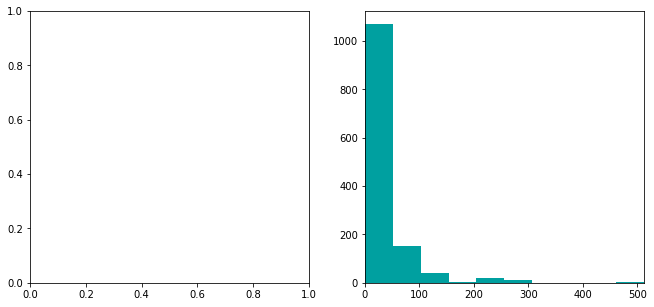

In [52]:
fig = plt.figure(figsize = (11,5));
ax = fig.add_subplot(1, 2, 1)
#ax.hist(features_raw.age,bins = 10, color = '#00A0A0')
#ax.set_xlim((0, features_raw.age.max()))
ax = fig.add_subplot(1, 2, 2)
ax.hist(features_raw.fare,bins = 10, color = '#00A0A0')
ax.set_xlim((0, features_raw.fare.max()))

(0, 6.240917354759096)

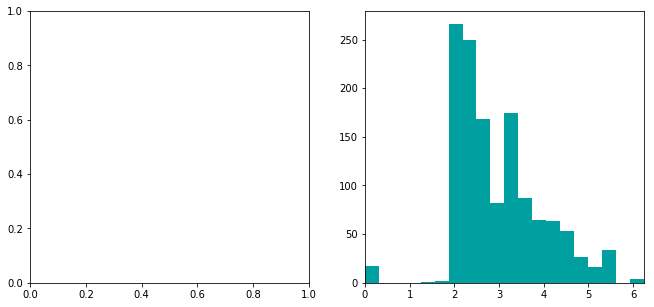

In [53]:
features_raw['fare'] = data['fare'].apply(lambda x: np.log(x + 1))
fig = plt.figure(figsize = (11,5));
ax = fig.add_subplot(1, 2, 1)
#ax.hist(features_raw.age,bins = 20, color = '#00A0A0')
#ax.set_xlim((0, features_raw.age.max()))
ax = fig.add_subplot(1, 2, 2)
ax.hist(features_raw.fare,bins = 20, color = '#00A0A0')
ax.set_xlim((0, features_raw.fare.max()))

In [77]:
features_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
embarked     1309 non-null object
fare         1309 non-null float64
parch        1309 non-null int64
pclass       1309 non-null float64
sex          1309 non-null object
sibsp        1309 non-null float64
title        1309 non-null object
age_categ    1309 non-null category
cabin_AZ     1309 non-null object
dtypes: category(1), float64(3), int64(1), object(4)
memory usage: 133.4+ KB


In [78]:
from sklearn.preprocessing import MinMaxScaler

# 初始化一个 scaler，并将它施加到特征上
scaler = MinMaxScaler()
features_raw.fare = scaler.fit_transform(features_raw['fare'].values.reshape(-1,1))
features_raw.pclass = scaler.fit_transform(features_raw['pclass'].values.reshape(-1,1))
features_raw.sibsp = scaler.fit_transform(features_raw['sibsp'].values.reshape(-1,1))

# 显示一个经过缩放的样例记录
display(features_raw.head(n = 1))

,embarked,fare,parch,pclass,sex,sibsp,title,age_categ,cabin_AZ
0,S,0.338125,0,1.0,male,0.125,Mr,"(20, 30]",None


In [79]:
features = pd.get_dummies(features_raw)
encoded = list(features.columns)
print ("独热编码后共得到{}个特征变量。 ".format(len(encoded)))

独热编码后共得到32个特征变量。 


In [80]:
features.head()

,fare,parch,pclass,sibsp,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,title_Master,...,"age_categ_(70, 100]",cabin_AZ_A,cabin_AZ_B,cabin_AZ_C,cabin_AZ_D,cabin_AZ_E,cabin_AZ_F,cabin_AZ_G,cabin_AZ_None,cabin_AZ_T
0,0.338125,0,1.0,0.125,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0.685892,0,0.0,0.125,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0.350727,0,1.0,0.000,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.639463,0,0.0,0.125,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0.352955,0,1.0,0.000,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [81]:
survived = survived_raw

In [82]:
X_train, X_test, y_train, y_test = features.iloc[:891,:],features.iloc[891:,:],survived[:891],survived[891:]

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0,stratify = y_train)

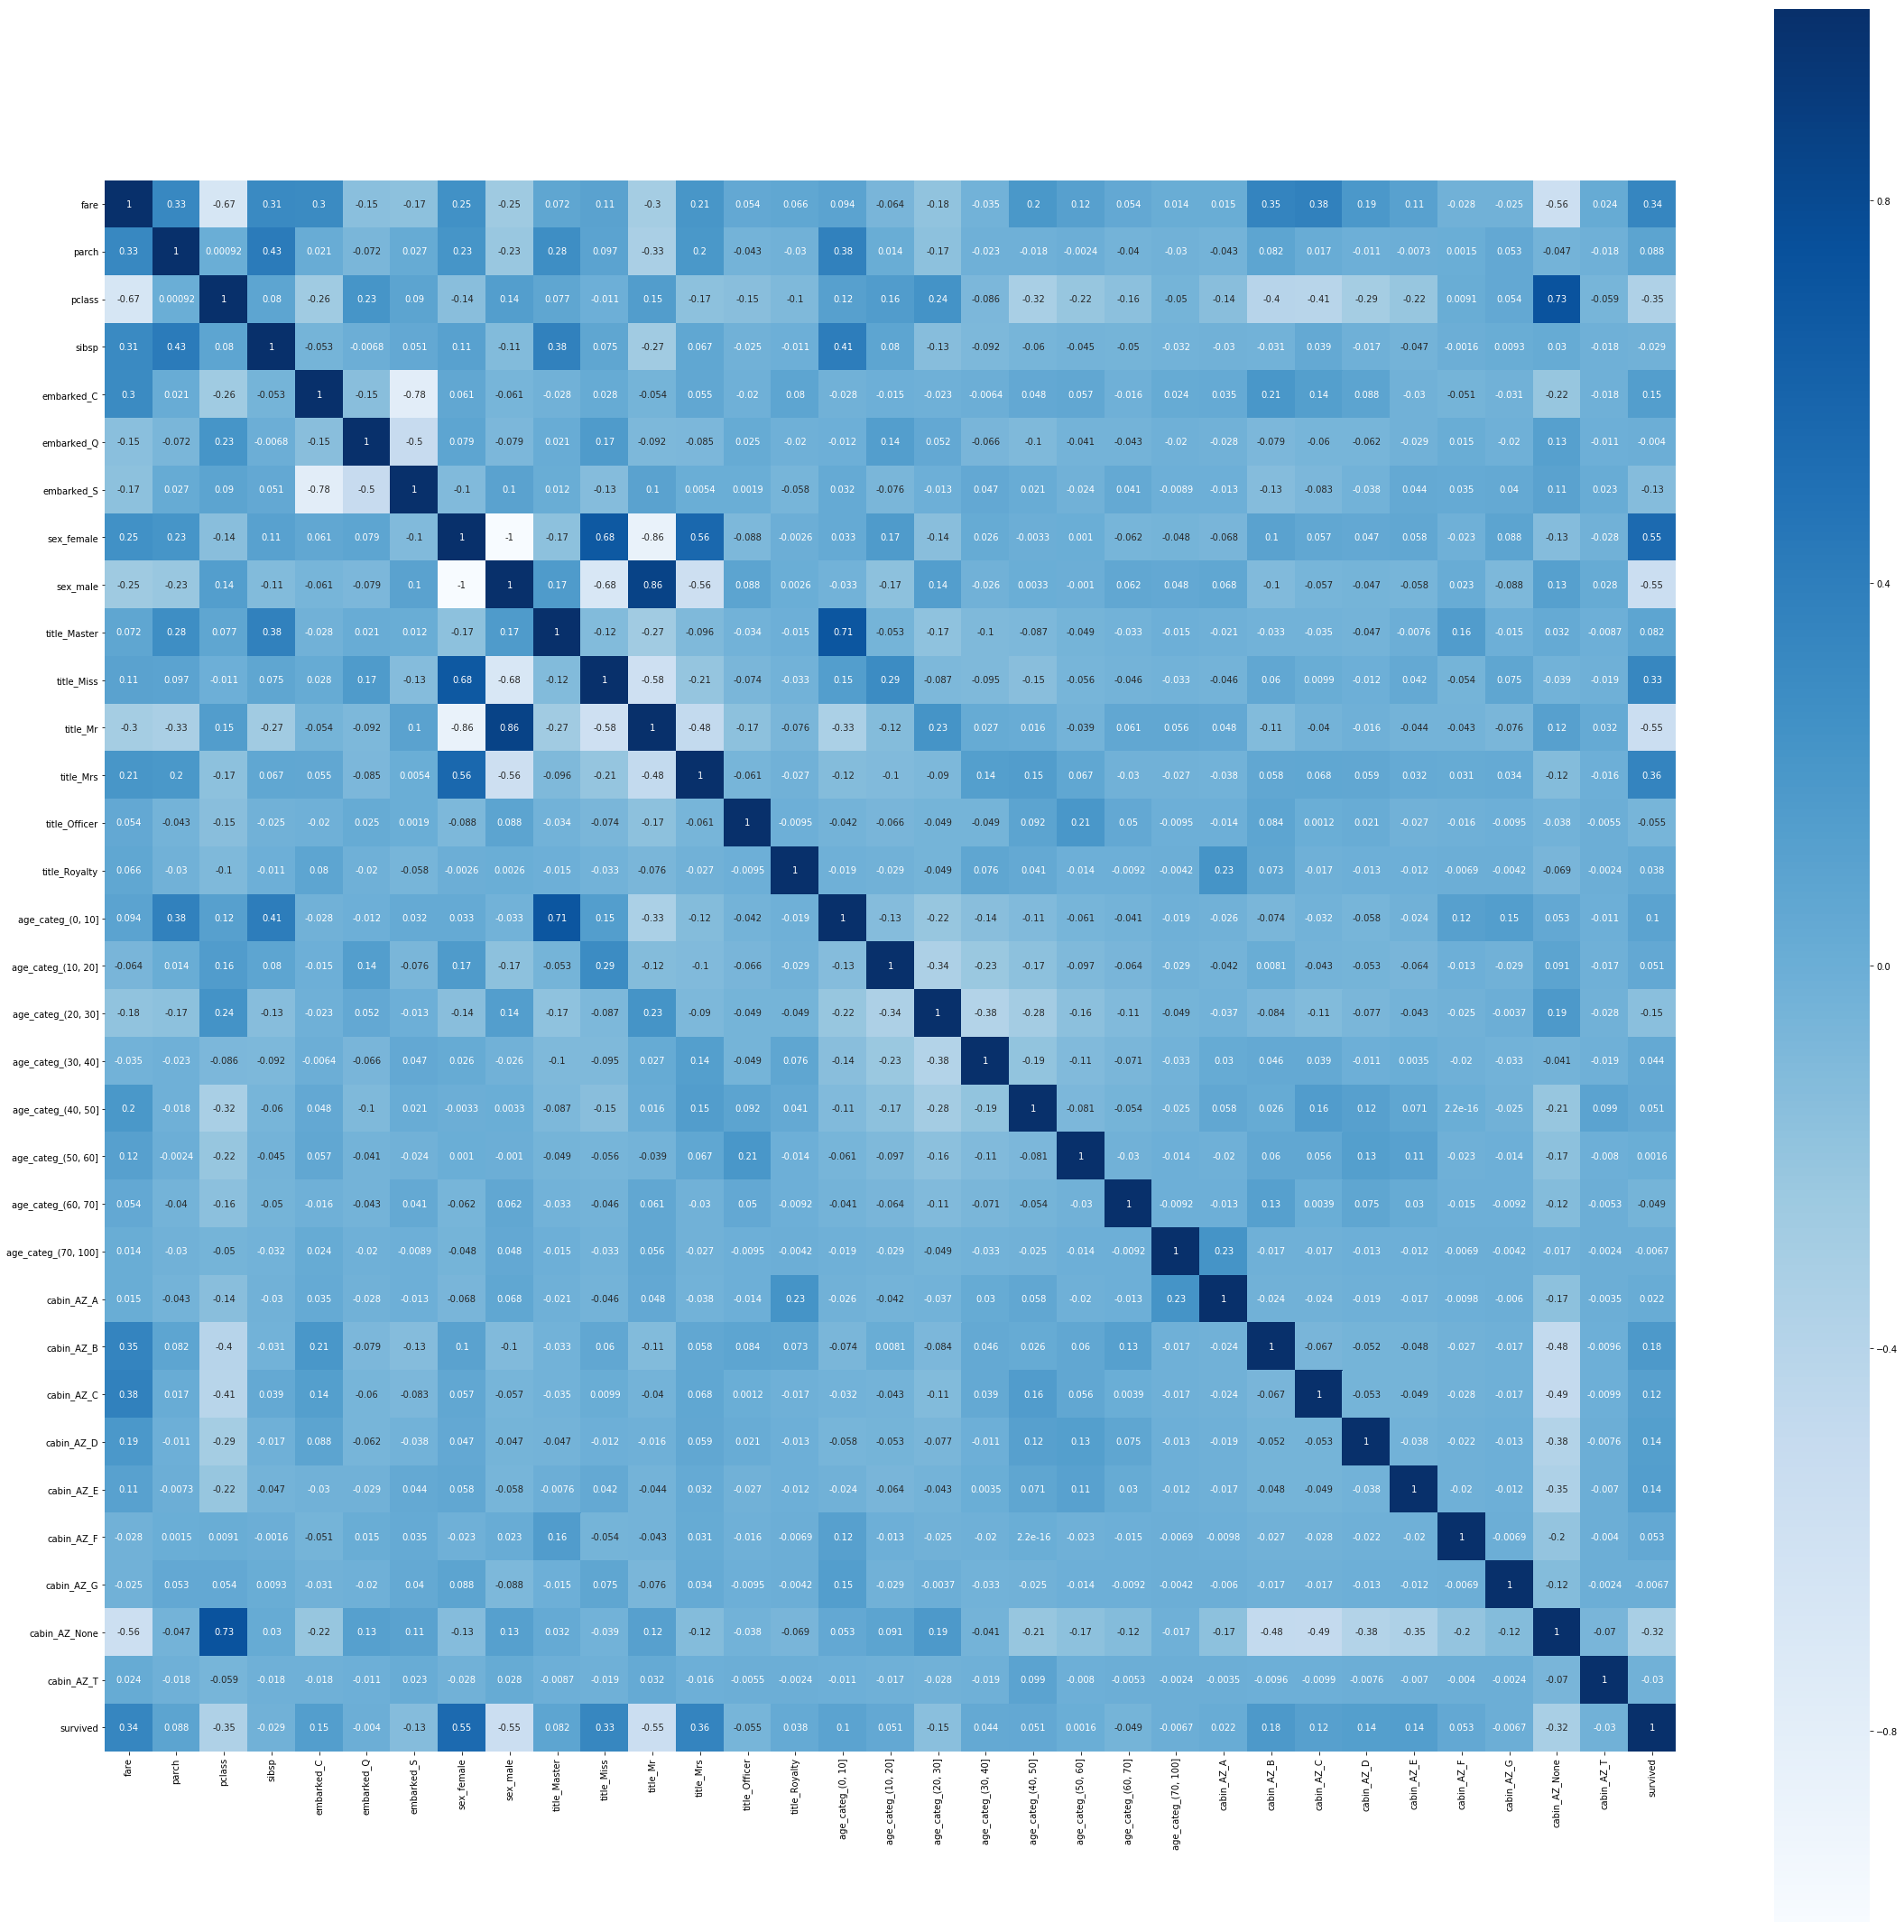

In [107]:
dfdata = X_train.join(y_train).corr()
plt.subplots(figsize=(39, 39)) # 设置画面大小
sb.heatmap(dfdata, annot=True, vmax=1, square=True, cmap="Blues")
plt.show()

In [3]:
from sklearn.datasets import load_iris
iris = load_iris()
iris.data[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [4]:
iris.target[:5]

array([0, 0, 0, 0, 0])

In [5]:
from sklearn.preprocessing import StandardScaler

StandardScaler().fit_transform(iris.data)

array([[-9.00681170e-01,  1.01900435e+00, -1.34022653e+00,
        -1.31544430e+00],
       [-1.14301691e+00, -1.31979479e-01, -1.34022653e+00,
        -1.31544430e+00],
       [-1.38535265e+00,  3.28414053e-01, -1.39706395e+00,
        -1.31544430e+00],
       [-1.50652052e+00,  9.82172869e-02, -1.28338910e+00,
        -1.31544430e+00],
       [-1.02184904e+00,  1.24920112e+00, -1.34022653e+00,
        -1.31544430e+00],
       [-5.37177559e-01,  1.93979142e+00, -1.16971425e+00,
        -1.05217993e+00],
       [-1.50652052e+00,  7.88807586e-01, -1.34022653e+00,
        -1.18381211e+00],
       [-1.02184904e+00,  7.88807586e-01, -1.28338910e+00,
        -1.31544430e+00],
       [-1.74885626e+00, -3.62176246e-01, -1.34022653e+00,
        -1.31544430e+00],
       [-1.14301691e+00,  9.82172869e-02, -1.28338910e+00,
        -1.44707648e+00],
       [-5.37177559e-01,  1.47939788e+00, -1.28338910e+00,
        -1.31544430e+00],
       [-1.26418478e+00,  7.88807586e-01, -1.22655167e+00,
      

In [106]:
dfdata.sort_values('survived')

,fare,parch,pclass,sibsp,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,title_Master,...,cabin_AZ_A,cabin_AZ_B,cabin_AZ_C,cabin_AZ_D,cabin_AZ_E,cabin_AZ_F,cabin_AZ_G,cabin_AZ_None,cabin_AZ_T,survived
sex_male,-0.254049,-0.225612,0.141335,-0.110036,-0.061200,-0.078733,0.103066,-1.000000,1.000000,0.170280,...,0.068024,-0.103639,-0.057206,-0.047328,-0.057652,2.287674e-02,-0.088156,0.130970,0.027673,-0.548748
title_Mr,-0.296374,-0.327872,0.149412,-0.267864,-0.053936,-0.091758,0.104896,-0.857288,0.857288,-0.268113,...,0.048272,-0.109423,-0.039567,-0.015846,-0.043859,-4.299956e-02,-0.075575,0.121889,0.032279,-0.548134
pclass,-0.668286,0.000923,1.000000,0.080498,-0.264746,0.225322,0.090113,-0.141335,0.141335,0.077370,...,-0.143891,-0.400589,-0.410206,-0.289839,-0.216966,9.144111e-03,0.054267,0.727503,-0.058536,-0.352219
cabin_AZ_None,-0.556866,-0.046710,0.727503,0.030109,-0.216807,0.128735,0.108864,-0.130970,0.130970,0.032096,...,-0.171231,-0.476703,-0.488148,-0.375803,-0.346913,-1.980014e-01,-0.120822,1.000000,-0.069659,-0.315932
"age_categ_(20, 30]",-0.180760,-0.171013,0.241758,-0.133903,-0.022562,0.052052,-0.012970,-0.144453,0.144453,-0.173436,...,-0.037293,-0.083581,-0.114246,-0.076832,-0.043149,-2.462711e-02,-0.003741,0.187434,-0.028186,-0.153613
embarked_S,-0.165305,0.026646,0.090113,0.050652,-0.783160,-0.500194,1.000000,-0.103066,0.103066,0.011647,...,-0.012602,-0.131156,-0.082976,-0.038477,0.044385,3.530874e-02,0.039808,0.108864,0.022951,-0.127260
title_Officer,0.054331,-0.043459,-0.146992,-0.025238,-0.020124,0.024980,0.001913,-0.087776,0.087776,-0.033854,...,-0.013524,0.084200,0.001229,0.020635,-0.027399,-1.563824e-02,-0.009543,-0.038174,-0.005502,-0.055343
"age_categ_(60, 70]",0.054389,-0.040221,-0.160481,-0.049849,-0.015967,-0.043352,0.041229,-0.062154,0.062154,-0.032682,...,-0.013056,0.131701,0.003930,0.075436,0.029600,-1.509715e-02,-0.009212,-0.117639,-0.005311,-0.049267
cabin_AZ_T,0.024183,-0.017539,-0.058536,-0.018261,-0.017974,-0.011480,0.022951,-0.027673,0.027673,-0.008655,...,-0.003457,-0.009625,-0.009856,-0.007588,-0.007004,-3.997826e-03,-0.002440,-0.069659,1.000000,-0.029574
sibsp,0.307372,0.428993,0.080498,1.000000,-0.052952,-0.006838,0.050652,0.110036,-0.110036,0.378137,...,-0.030375,-0.031297,0.039342,-0.016605,-0.046836,-1.555809e-03,0.009292,0.030109,-0.018261,-0.029246


In [87]:
# TODO：导入'GridSearchCV', 'make_scorer'和其他一些需要的库
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, accuracy_score,recall_score,precision_score
from sklearn import linear_model
import warnings
import datetime
import time
print('start')
#warnings.filterwarnings('ignore')
# TODO：初始化分类器
#clf = RandomForestClassifier(random_state = 24)
clf = linear_model.LogisticRegression(random_state = 24,penalty='l2', tol=1e-6)
#
#start=time()

# TODO：创建你希望调节的参数列表
#parameters = {"max_depth":[2,4,6,8], "min_samples_leaf":[2,4,6,8,10],"n_estimators":[3,10,30], "min_samples_split":[2,4,6,8,10]}
parameters = {"max_iter":range(1,15,2), "C":[0.7,0.8,0.9,1.0], "intercept_scaling":[0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2]}

# TODO：创建一个fbeta_score打分对象
scorer = make_scorer(fbeta_score,beta=0.5)

# TODO：在分类器上使用网格搜索，使用'scorer'作为评价函数
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring = scorer)

# TODO：用训练数据拟合网格搜索对象并找到最佳参数
grid_fit = grid_obj.fit(X_train, y_train)

# 得到estimator
best_clf = grid_obj.best_estimator_
# 使用没有调优的模型做预测
predictions = (clf.fit(X_train, y_train)).predict(X_val)
best_predictions = best_clf.predict(X_val)

# 汇报调优后的模型
print ("best_clf\n------")
print (best_clf)
#end = time() # 获得程序结束时间
    
# TODO：计算预测用时
#print('运行时间',end-start)
# 汇报调参前和调参后的分数
print ("\nUnoptimized model\n------")
print ("Accuracy score on validation data: {:.4f}".format(accuracy_score(y_val, predictions)))
print ("F-score on validation data: {:.4f}".format(fbeta_score(y_val, predictions, beta = 0.5)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the validation data: {:.4f}".format(accuracy_score(y_val, best_predictions)))
print ("Final precision score on the validation data: {:.4f}".format(precision_score(y_val, best_predictions)))
print ("Final F-score on the validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5)));

start
best_clf
------
LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1.2, l1_ratio=None, max_iter=5,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=24, solver='warn', tol=1e-06, verbose=0,
                   warm_start=False)

Unoptimized model
------
Accuracy score on validation data: 0.8156
F-score on validation data: 0.7767

Optimized Model
------
Final accuracy score on the validation data: 0.8156
Final precision score on the validation data: 0.8000
Final F-score on the validation data: 0.7767


In [ ]:
start
best_clf
------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=2.2, l1_ratio=None, max_iter=13,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=24, solver='warn', tol=1e-06, verbose=0,
                   warm_start=False)

Unoptimized model
------
Accuracy score on validation data: 0.8045
F-score on validation data: 0.7605

Optimized Model
------
Final accuracy score on the validation data: 0.8268
Final precision score on the validation data: 0.8276
Final F-score on the validation data: 0.7973

In [91]:
from sklearn import linear_model
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=1e-06, verbose=0,
                   warm_start=False)

In [88]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import f1_score, accuracy_score,precision_score,fbeta_score,recall_score
best_predictions = best_clf.predict(X_val)

print ("Final accuracy score on the validation data: {:.4f}".format(accuracy_score(y_val, best_predictions)))
print ("Final precision score on the validation data: {:.4f}".format(precision_score(y_val, best_predictions)))
print ("Final F-score on the validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5)));

Final accuracy score on the validation data: 0.8156
Final precision score on the validation data: 0.8000
Final F-score on the validation data: 0.7767


In [89]:

print ("Final accuracy score on the validation data: {:.4f}".format(accuracy_score(y_val, best_predictions)))
print ("Final precision score on the validation data: {:.4f}".format(precision_score(y_val, best_predictions)))
print ("Final F-score on the validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5)));

Final accuracy score on the validation data: 0.8156
Final precision score on the validation data: 0.8000
Final F-score on the validation data: 0.7767


In [90]:
predictions = (best_clf.predict(X_train))
print('accuracy_score',accuracy_score(y_train, predictions))
print('precision_score',precision_score(y_train, predictions))
print('recall_score',recall_score(y_train, predictions))
print ("Final F-score on the validation data: {:.4f}".format(fbeta_score(y_train, predictions, average='weighted', beta = 1.3)));

accuracy_score 0.8370786516853933
precision_score 0.79182156133829
recall_score 0.7802197802197802
Final F-score on the validation data: 0.8369


In [121]:
predictions = (best_clf.predict(X_test))

In [122]:
predictions.shape

(418,)

In [325]:
predictions = best_clf.predict(X_test)
result = pd.DataFrame({'PassengerId':test['passengerid'].as_matrix(), 'Survived':predictions.astype(np.int32)})
result.to_csv("logistic_regression_predictions.csv", index=False)

In [319]:
coef_df = pd.DataFrame({"columns":list(X_train.columns), "coef":list(best_clf.coef_.T)}).sort_values("coef")

In [320]:
coef_df.iloc[:,:]

,columns,coef
3,sibsp,[-2.1176895645188294]
2,pclass,[-1.4594322594007068]
11,title_Mr,[-0.9776021904027947]
13,title_Officer,[-0.823970560351929]
21,"age_categ_(60, 70]",[-0.7932350720957341]
20,"age_categ_(50, 60]",[-0.6846644730061346]
8,sex_male,[-0.6821282983695676]
29,cabin_AZ_G,[-0.6424301510651799]
30,cabin_AZ_None,[-0.49886140859813194]
1,parch,[-0.3796327120408722]


第一次得分0.760  

第二次调整:  
passengerid 0 去掉  
title_Royalty	[0.002  
age [-0.042] 年龄ing进行分段  
第二次得分：0.76555  